In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import zipfile
import cv2
import itertools

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_name = '/content/drive/Othercomputers/My Computer/Computer vision/projects/dl and cnns/classification chest x rays/chest x ray images.zip'
# file_name = './chest x ray images.zip'
dir='./'
zip_ref = zipfile.ZipFile(file_name, 'r')
zip_ref.extractall(dir)
zip_ref.close()

In [4]:
print('number of normal training images: ', len(os.listdir('./chest_xray/train/NORMAL')))
print('number of pneumonia training images: ', len(os.listdir('./chest_xray/train/PNEUMONIA')))
print('number of normal testing images: ', len(os.listdir('./chest_xray/test/NORMAL')))
print('number of pneumonia testing images: ', len(os.listdir('./chest_xray/test/PNEUMONIA')))

number of normal training images:  1341
number of pneumonia training images:  3875
number of normal testing images:  234
number of pneumonia testing images:  390


In [5]:
TRAINIG_DIR = './chest_xray/train/'
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest').flow_from_directory(
        TRAINIG_DIR,
        batch_size=16,
        class_mode='binary',
        target_size=(224, 224)
    )

VALIDATION_DIR = './chest_xray/val/'
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(VALIDATION_DIR, batch_size=16, class_mode='binary', target_size=(224, 224))

TESTING_DIR = './chest_xray/test/'
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(TESTING_DIR, batch_size=16, class_mode='binary', target_size=(224, 224))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout

# Baseline model
model = Sequential([
    Conv2D(16, 3, activation='relu', input_shape=(224,224,3)),
    MaxPool2D(),
    Dropout(0.5),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(),
    Dropout(0.5),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

In [7]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
#Overwrite the model each time accuracy improves. Saves a lot of space. 
filepath="./best_model.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, accuracy, loss, val_accuracy, val_loss. So we can plot later.
log_csv = CSVLogger('/content/drive/MyDrive/Colab Notebooks/saved_logs/my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint]
tb = TensorBoard(log_dir='.')

In [8]:
class_weight = {0: 0.76, 1: 0.24}

In [9]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    class_weight=class_weight,
    epochs=5,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/5
326/326 [==============================] - ETA: 0s - loss: 0.1966 - accuracy: 0.7048
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to ./best_model.hdf5
326/326 [==============================] - 110s 298ms/step - loss: 0.1966 - accuracy: 0.7048 - val_loss: 0.7978 - val_accuracy: 0.6250
Epoch 2/5
326/326 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.8426
Epoch 2: val_accuracy improved from 0.62500 to 0.68750, saving model to ./best_model.hdf5
326/326 [==============================] - 99s 303ms/step - loss: 0.1301 - accuracy: 0.8426 - val_loss: 0.5122 - val_accuracy: 0.6875
Epoch 3/5
326/326 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.8564
Epoch 3: val_accuracy did not improve from 0.68750
326/326 [==============================] - 98s 301ms/step - loss: 0.1253 - accuracy: 0.8564 - val_loss: 0.6374 - val_accuracy: 0.6250
Epoch 4/5
326/326 [==============================] - ETA: 0s - loss: 0.1214 - accura

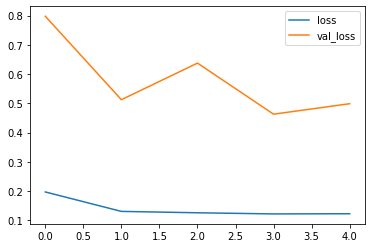

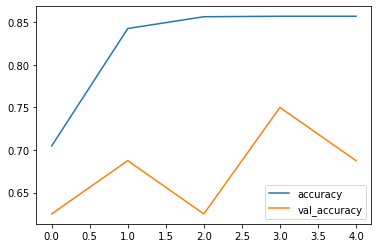

In [10]:
### with pandas
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [11]:
loss, accuracy = model.evaluate(test_generator, batch_size=32)
print(loss, accuracy)

39/39 [==============================] - 6s 160ms/step - loss: 0.3915 - accuracy: 0.8029
0.39149004220962524 0.8028846383094788


[[ 65 169]
 [116 274]]


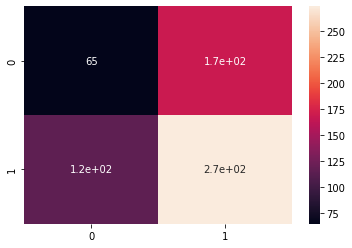

In [12]:
from sklearn.metrics import confusion_matrix

test_labels = test_generator.classes
predictions = model.predict(test_generator)
predictions = predictions.reshape(1,-1)[0]
cm = confusion_matrix(y_true=test_labels, y_pred=np.round(predictions))
print(cm)
sns.heatmap(cm, annot=True)